In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import matplotlib
plt.style.use(['plorts', 'plorts-print', 'plorts-neon', './buffer-workshop.mplstyle'])
width = 7.141
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [4]:
df = pd.read_sql("""
select num_flows, max_queue_depth_packets, algorithm, count(*)
from traces
inner join experiments on experiments.id = traces.experiment_id
where note in ('postcard', 'postcard-ecn', 'postcard-reno')
and algorithm in ('reno', 'scalable', 'cubic', 'bbr')
and action = 'drop'
group by 1,2,3
""", con)
df.head()

,num_flows,max_queue_depth_packets,algorithm,count
0,16,177.777778,bbr,54064
1,4,88.888889,scalable,62146
2,1,88.888889,reno,94501
3,16,44.444444,cubic,73835
4,8,8.888889,bbr,49848


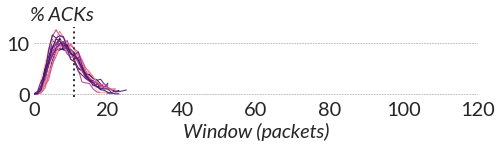

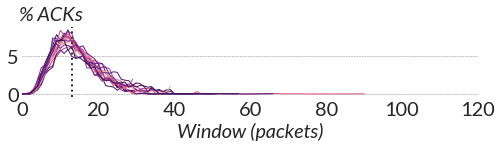

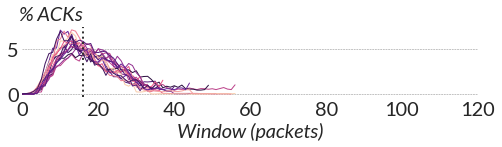

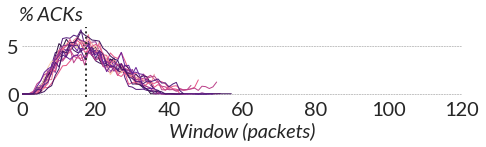

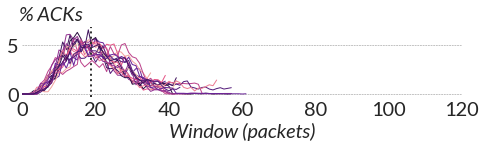

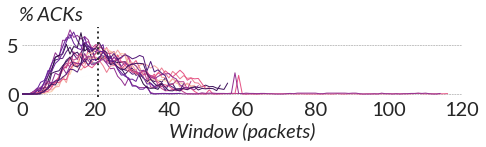

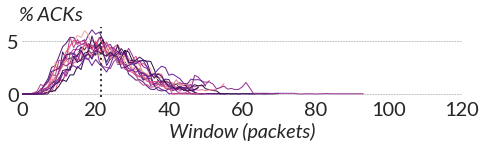

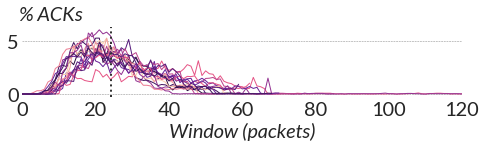

In [50]:
bdp = 166
n = 16


distribution_stats = []

for B, nfdf in df.sort_values('max_queue_depth_packets').groupby('max_queue_depth_packets'):
    plt.figure(figsize=(width, 1/3*width))
    
    cwnds = []
    for flow,fdf in nfdf.groupby(['sport', 'dport']):
        if len(fdf) < 100: continue

        max_cwnd = fdf.snd_cwnd.max()
        ys,xs = np.histogram(fdf.snd_cwnd, bins=np.arange(0,max_cwnd,1))
        ys = np.divide(ys, sum(ys))*100

        plt.plot(xs[:-1], ys, label=flow, linewidth=1)
        cwnds.extend(fdf.snd_cwnd)
        
    cwnds = np.array(cwnds)
    for quantile in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
        distribution_stats.append([B, quantile, np.quantile(cwnds, quantile)])
    mean = (bdp + B)/n
    distribution_stats.append([B, 0, np.min(cwnds)])
    distribution_stats.append([B, 100, np.max(cwnds)])
    distribution_stats.append([B, "iqr", np.quantile(cwnds, 0.75) - np.quantile(cwnds, 0.25)])
    distribution_stats.append([B, "99-range", np.quantile(cwnds, 0.99) - np.quantile(cwnds, 0.01)])
    distribution_stats.append([B, "normalized-99-range", (np.quantile(cwnds, 0.99) - np.quantile(cwnds, 0.01))/mean])
    distribution_stats.append([B, "normalized-range", (np.max(cwnds) - np.min(cwnds))/mean])
    distribution_stats.append([B, "normalized-max", (np.max(cwnds))/mean])
    distribution_stats.append([B, "normalized-min", (np.min(cwnds))/mean])
    distribution_stats.append([B, "normalized-99", (np.quantile(cwnds, 0.99))/mean])
    distribution_stats.append([B, "normalized-01", (np.quantile(cwnds, 0.01))/mean])
    distribution_stats.append([B, "range", np.max(cwnds) - np.min(cwnds)])
    distribution_stats.append([B, "mean", np.mean(cwnds)])

    plt.axvline(x=(bdp + B)/n, linestyle=":", color='#333333')
#    plt.text((bdp + B)/n+1, 6, "Fair share", fontweight='bold', color='#333333')

    plt.xlabel("Window (packets)")
    plt.ylabel("% ACKs")
    plorts.style_axis()
    plt.axis(xmin=0, xmax=120)

    plt.savefig(f"../figures/fairness_reno_drop_{n}_{bdp}.png")